In [1]:
from preprocessing import (
    preprocess_kjv,
    get_word_types_with_tf_idf,
    get_gospel_top_70_words_dictionary,
)
from extract_relations import (
    get_directed_relations,
    order_directed_relations,
)
from ontology_algorithm import (
    construct_ontology_hierarchy,
    print_hierarchy_tree_from_ontology,
    draw_hierarchy_tree_from_ontology,
)
from topic_modeling import (
    kmeans_tfidf_clustering,
    filter_topic_modeling_key_terms,
)
import re

## Preprocessing

We will preprocess words from the theology reconsidered text using tf-idf and extract the top n words.

In [2]:
theology_reconsidered_path = "/Users/zebo/Documents/Freelancing/upwork/Peter_J_Worth_Jr/NLP/hierarchical_clustering/data/theology_reconsidered.txt"

with open(theology_reconsidered_path, "r") as f:
    theology_reconsidered = f.read()


def split_into_chapters(input_filename, verbose=False):
    """Split the input file into chapters."""
    titles = []
    chapters = []
    # Open the input file and read its contents
    with open(input_filename, "r", encoding="utf-8") as input_file:
        contents = input_file.read()

    # Split the contents into chunks based on the separator criteria
    chunks = contents.split("\n\n\n\n")  # empty lines in the text

    ch_cnt = 0

    # Create an output file for each chunk
    for i, chunk in enumerate(chunks):
        # Skip empty chunks
        if not chunk.strip():
            continue

        # Extract the title and content from the chunk
        lines = chunk.strip().split("\n")
        title = lines[0]
        content = "\n".join(lines[1:])

        if verbose:
            print("processing CH" + str(ch_cnt) + ": " + title + "...")

        # Create the output file
        chapters.append(content)
        titles.append(title)

        ch_cnt += 1
    return titles, chapters


titles, chapters = split_into_chapters(theology_reconsidered_path)

chapters[0]

# Should I remove the word Figure?

# Remove \n from the chapters.
chapters = [chapter.replace("\n", "") for chapter in chapters]
# Remove \t from the chapters.
chapters = [chapter.replace("\t", " ") for chapter in chapters]


# import re

# Separate the chapters into sentences.
sentences_per_chapter_prep = [re.split("\.  ", chapter) for chapter in chapters]
sentences_per_chapter_prep = [
    [sentence + "." for sentence in chapter] for chapter in sentences_per_chapter_prep
]

sentences_per_chapter = []
for chapter_prep in sentences_per_chapter_prep:
    chapter = []
    for sentence in chapter_prep:
        chapter.extend(re.split("(?<!i.e|etc|e.g|iii)\. ", sentence))
    sentences_per_chapter.append(chapter)

# sentences_per_chapter[0]
for title_index, title in enumerate(titles):
    print(title_index, title)

0 Introduction
1 Prologue: Mythos and Mysticism in Antiquity
2 A Brief History of the Mystical Arts: Beyond Yoga
3 Meditation as a Mystical Art: A Bridge Through Time 
4 Overarching Themes: The Laurasian Hypothesis and a New Metaphysics
5 Setting the Stage: A Brief of History of Modern Man
6 Part I: On Creation Mythos (Cosmogony)
7 From Language to Writing: The Dawn of History
8 The Ancient Hebrews: The Tanakh, Torah and Five Books of Moses
9 Ancient Egyptian Mythos: The Weighing of the Heart, Ra and Ma'at
10 The Enûma Eliš: Sumer- Babylonian Creation Mythos
11 Ancient Persian Theology: Zarathustra and the Avesta
12 Classic Hellenic Theogony: Chaos, Chronos and Eros
13 Orphic Theogony: Thanes and the Great Cosmic Egg
14 Vedic Cosmogony: Skepticism, Puruṣa and Hiraṇyagarbha 
15 Ancient Chinese Theology: Shàngdì, Pángǔ, Tiān and the Dao
16 Roman Cosmogony: The Metamorphoses of Ovid
17 Eurasian Mythos: Establishing the Laurasian Hypothesis 
18 Part II: On Ancient Philosophy (Logos)
19 Fro

In [3]:
# Remove chapters, titles and sentences if the title starts with "Part ".
title_indices_to_remove = [
    title_index for title_index, title in enumerate(titles) if title.startswith("Part ")
]

titles = [
    title
    for title_index, title in enumerate(titles)
    if title_index not in title_indices_to_remove
]
sentences_per_chapter = [
    chapter
    for chapter_index, chapter in enumerate(sentences_per_chapter)
    if chapter_index not in title_indices_to_remove
]
chapters = [
    chapter
    for chapter_index, chapter in enumerate(chapters)
    if chapter_index not in title_indices_to_remove
]

## Perform topic modeling

In [4]:
NUM_TOPICS = 8
clusters, key_terms_per_cluster = kmeans_tfidf_clustering(
    chapters=chapters,
    num_topics=NUM_TOPICS,
    n_key_terms=10,
)

CLUSTER #1
Cluster Chapters: [1, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 28, 30]
Key Features: ['ancient', 'tradition', 'creation', 'gods', 'mythos', 'also', 'well', 'one', 'greek', 'philosophical']
CLUSTER #2
Cluster Chapters: [43, 51]
Key Features: ['quality', 'pirsig', 'static', 'metaphysics', 'dynamic', 'experience', 'reality', 'subject object', 'metaphysics quality', 'static quality']
CLUSTER #3
Cluster Chapters: [20, 21, 23, 24, 27, 45]
Key Features: ['knowledge', 'plato', 'brahman', 'socrates', 'suffering', 'philosophical', 'soul', 'vedānta', 'one', 'philosophy']
CLUSTER #4
Cluster Chapters: [0, 2, 3, 4, 5, 22, 29, 31, 46, 47]
Key Features: ['philosophical', 'yoga', 'ramakrishna', 'ancient', 'well', 'theo', 'philosophy', 'work', 'theo philosophical', 'also']
CLUSTER #5
Cluster Chapters: [37, 38, 39, 40, 41, 48]
Key Features: ['quantum', 'mechanics', 'theory', 'reality', 'relativity', 'quantum theory', 'einstein', 'quantum mechanics', 'subatomic', 'physics']
CLUSTER #6
Cluster Chapte

In [5]:
# Specify the chapters used in the analysis.
chosen_cluster = 7
use_key_terms = True
chosen_hierarchy_depth = 5
chosen_hierarchy_max_width = None

chosen_chapters = clusters[chosen_cluster]

chapter_titles = [titles[i] for i in chosen_chapters]
key_terms = key_terms_per_cluster[chosen_cluster]

print("Chosen chapters ", chosen_chapters)

text_per_chapter = []
for chapter_idx in chosen_chapters:
    text_per_chapter.append(chapters[chapter_idx])

tf_idf_pre_filtering = get_word_types_with_tf_idf(
    text_per_chapter,
    "tf",
    skip_stopwords=True,
    include_verbs=False,
    include_determiners=False,
    include_pronouns=False,
    include_adverbs=False,
    include_numbers=True,
)

if use_key_terms:
    current_level_words = filter_topic_modeling_key_terms(
        key_terms=key_terms_per_cluster[chosen_cluster],
        tf_idf_word_types=tf_idf_pre_filtering,
        verbose=True,
    )
    current_level_words.append("dàodé jīng")  # TODO: Remove this.
else:
    # raise NotImplementedError("Not implemented yet.")
    # Specify the number of top words to use.
    n = max(50, len(chosen_chapters) * 5)
    current_level_words = tf_idf_pre_filtering.head(n)["word"].values

# Create a list of all verses of the chosen books.
all_verses = []
for chapter_idx in chosen_chapters:
    all_verses.extend(sentences_per_chapter[chapter_idx])

used_words = set()
all_ordered_directed_relations = []
all_relations_to_verbs = {}


# First, let's see relations between the key terms.
directed_relations, relations_to_verbs = get_directed_relations(
    top_n_words=current_level_words,
    all_verses=all_verses,
    verbose=False,
    only_compounds=False,
)

# Order the directed relations.
ordered_directed_relations = order_directed_relations(
    directed_relations=directed_relations,
    tf_idf_pre_filtering=tf_idf_pre_filtering,
    order_by="product",
    include_ordering_wrt_occurences=True,
    verbose=False,
)

for relation in ordered_directed_relations:
    if relation[0] in current_level_words and relation[1] in current_level_words:
        current_level_words.remove(relation[1])
        print(
            "Removing ",
            relation[1],
            " from current_level_words, it will be a child of ",
            relation[0],
        )

# Now lets see all relations that come out of the key terms.
directed_relations, relations_to_verbs = get_directed_relations(
    top_n_words=current_level_words,
    all_verses=all_verses,
    verbose=True,
    get_all_one_directional="lower",
    only_compounds=False,
)
print("All children: ", [relation[1] for relation in directed_relations])

Chosen chapters  [14, 17, 18, 19, 25, 26, 44]
Removing the following terms:  []
Removing  one  from current_level_words, it will be a child of  chinese
Removing  heaven  from current_level_words, it will be a child of  dao
Removing  chinese  from current_level_words, it will be a child of  dàodé jīng

 1  sentences in verse  0
sentence:  Before the evolution of the more esoteric and all-encompassing principle of Heaven (Tiān) which we find so prevalent in classical Chinese philosophical circles after the advent of the Zhou Dynasty, the primary divine entity that is worshipped and looked to as the source of universal order is called Shàngdì, which of course gets its name from the dynastic period of China within which it plays such a prominent theological role.
ents:  [Tiān, Chinese, the Zhou Dynasty, Shàngdì, China]
subject:  we
object:  which
object:  advent
object:  Dynasty
Compounds:  ['Zhou']
subject:  that
Using conjunct subject:  that
subject:  source
subject:  which
object:  cour

In [6]:
# # Specify the chapters used in the analysis.
# chosen_cluster = 7
# use_key_terms = True
# chosen_hierarchy_depth = 5
# chosen_hierarchy_max_width = None

# chosen_chapters = clusters[chosen_cluster]

# chapter_titles = [titles[i] for i in chosen_chapters]
# key_terms = key_terms_per_cluster[chosen_cluster]

# print("Chosen chapters ", chosen_chapters)

# text_per_chapter = []
# for chapter_idx in chosen_chapters:
#     text_per_chapter.append(chapters[chapter_idx])

# tf_idf_pre_filtering = get_word_types_with_tf_idf(
#     text_per_chapter,
#     "tf",
#     skip_stopwords=True,
#     include_verbs=False,
#     include_determiners=False,
#     include_pronouns=False,
#     include_adverbs=False,
#     include_numbers=True,
# )

In [7]:
# all_trigrams = [word for word in tf_idf_pre_filtering["word"].values if len(word.split()) == 3]
# for trigram in all_trigrams:
#     print(trigram)
# print(len(all_trigrams))

## Run the workflow on one cluster

Chosen chapters  [14, 17, 18, 19, 25, 26, 44]
Removing the following terms:  []
Removing  one  from current_level_words, it will be a child of  heaven
Removing  heaven  from current_level_words, it will be a child of  dao

 Current level:  0
All children:  ['which', 'direct ancient ancestors', 'that', 'order', 'english', 'this', 'history', 'one', 'which', 'establishment', 'civilization', 'which', 'bygone age', 'justice', 'distinct philosophical system', 'trigrams', 'what', 'place', 'universal world order', 'ethical moral foundations', 'state', 'lu', 'eastern china', 'fact', 'class', 'priests', 'profound influence', 'many', 'lǎozǐ', 'one', 'things', 'classical chinese', 'what', 'things', 'myriad', 'different aspects', 'pattern', 'heaven', 'laws', 'more', 'individual spiritual focus', 'similar process', 'sifting process', 'lasting philosophical systems', 'daoism', 'example']
Children to remove due to tf_idf_pre_filtering:  ['which', 'that', 'this', 'which', 'which', 'what', 'what', 'more

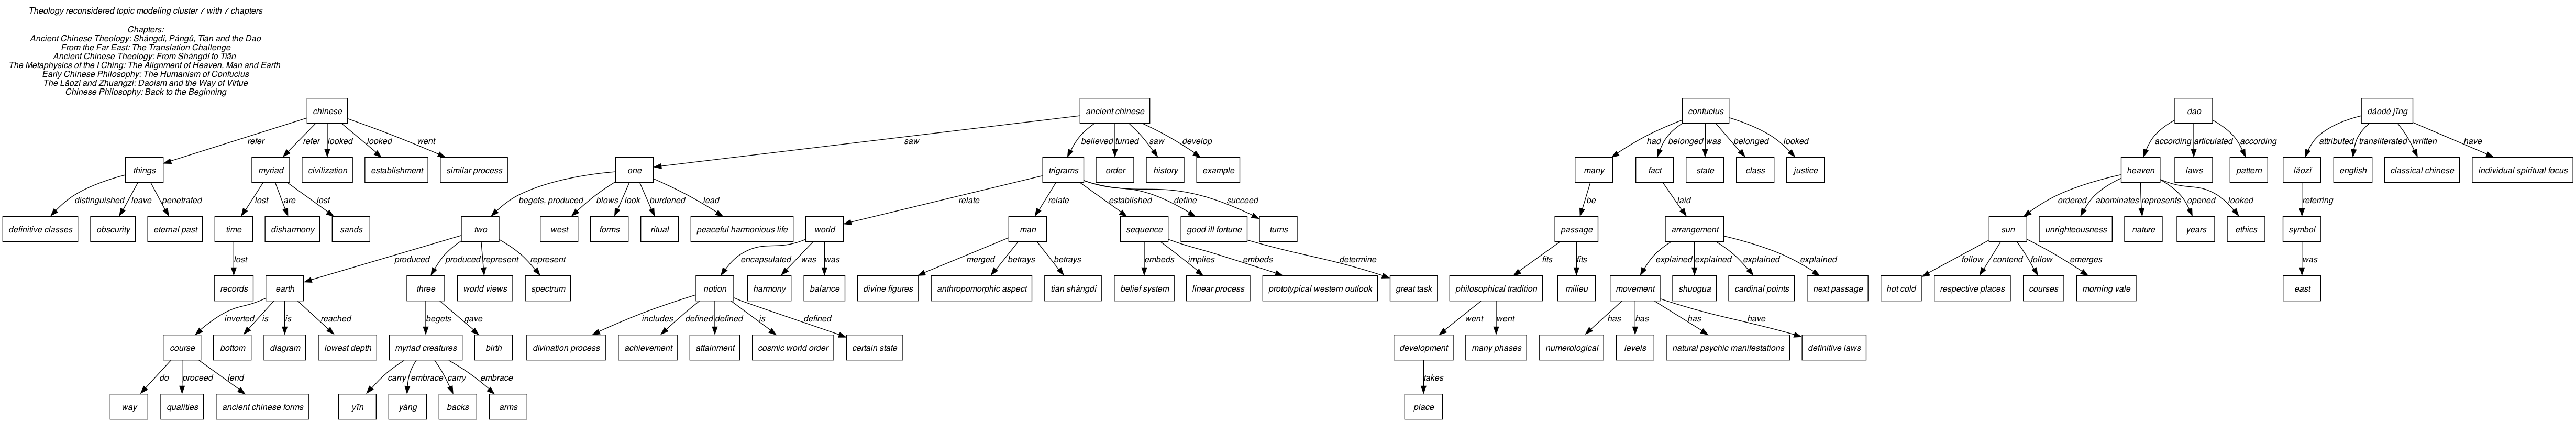

In [8]:
# Specify the chapters used in the analysis.
chosen_cluster = 7
use_key_terms = True
chosen_hierarchy_depth = 5
chosen_hierarchy_max_width = 5
only_compounds = True

chosen_chapters = clusters[chosen_cluster]

chapter_titles = [titles[i] for i in chosen_chapters]
key_terms = key_terms_per_cluster[chosen_cluster]

print("Chosen chapters ", chosen_chapters)

text_per_chapter = []
for chapter_idx in chosen_chapters:
    text_per_chapter.append(chapters[chapter_idx])

tf_idf_pre_filtering = get_word_types_with_tf_idf(
    text_per_chapter,
    "tf",
    skip_stopwords=True,
    include_verbs=False,
    include_determiners=False,
    include_pronouns=False,
    include_adverbs=False,
    include_numbers=True,
)

if use_key_terms:
    current_level_words = filter_topic_modeling_key_terms(
        key_terms=key_terms_per_cluster[chosen_cluster],
        tf_idf_word_types=tf_idf_pre_filtering,
        verbose=True,
    )
    current_level_words.append("dàodé jīng")  # TODO: Remove this.
else:
    raise NotImplementedError("Not implemented yet.")
    # Specify the number of top words to use.
    n = max(50, len(chosen_chapters) * 5)
    current_level_words = tf_idf_pre_filtering.head(n)["word"].values

# Create a list of all verses of the chosen books.
all_verses = []
for chapter_idx in chosen_chapters:
    all_verses.extend(sentences_per_chapter[chapter_idx])

used_words = set()
all_ordered_directed_relations = []
all_relations_to_verbs = {}

# First, let's see relations between the key terms.
directed_relations, relations_to_verbs = get_directed_relations(
    top_n_words=current_level_words,
    all_verses=all_verses,
    verbose=False,
    only_compounds=only_compounds,
)

# Order the directed relations.
ordered_directed_relations = order_directed_relations(
    directed_relations=directed_relations,
    tf_idf_pre_filtering=tf_idf_pre_filtering,
    order_by="product",
    include_ordering_wrt_occurences=True,
    verbose=False,
)

for relation in ordered_directed_relations:
    if relation[0] in current_level_words and relation[1] in current_level_words:
        current_level_words.remove(relation[1])
        print(
            "Removing ",
            relation[1],
            " from current_level_words, it will be a child of ",
            relation[0],
        )


for current_level in range(chosen_hierarchy_depth):
    print("\n Current level: ", current_level)

    if len(current_level_words) == 0:
        break

    # Now lets see all relations that come out of the key terms.
    directed_relations, relations_to_verbs = get_directed_relations(
        top_n_words=current_level_words,
        all_verses=all_verses,
        verbose=False,
        get_all_one_directional="lower",
        only_compounds=only_compounds,
    )
    print("All children: ", [relation[1] for relation in directed_relations])

    # Filter out the relations whose children is not in tf_idf_pre_filtering
    # and it has not been used already, but print them out first.
    children_to_remove_1 = [
        key[1]
        for key, _ in directed_relations.items()
        if key[1] not in tf_idf_pre_filtering["word"].values
    ]
    # Keep the bigrams and trigrams which are not in tf_idf_pre_filtering but
    # all of their words are in tf_idf_pre_filtering.
    children_to_remove_1 = [
        child
        for child in children_to_remove_1
        if not (
            len(child.split(" ")) > 1
            and all(
                word in tf_idf_pre_filtering["word"].values for word in child.split(" ")
            )
        )
    ]
    print("Children to remove due to tf_idf_pre_filtering: ", children_to_remove_1)

    children_to_remove_2 = [
        key[1] for key, _ in directed_relations.items() if key[1] in used_words
    ]
    print("Children to remove due to used words: ", children_to_remove_2)

    directed_relations = {
        key: value
        for key, value in directed_relations.items()
        if key[1] not in children_to_remove_1 and key[1] not in children_to_remove_2
    }

    # Order the directed relations.
    ordered_directed_relations = order_directed_relations(
        directed_relations=directed_relations,
        tf_idf_pre_filtering=tf_idf_pre_filtering,
        order_by="product",
        include_ordering_wrt_occurences=True,
        verbose=False,
    )

    # Constrain at most chosen_hierarchy_max_width relations per key term.
    if chosen_hierarchy_max_width is not None:
        counter = {}
        relations_to_remove = []
        for idx, relation in enumerate(ordered_directed_relations):
            if relation[0] in counter:
                counter[relation[0]] += 1
            else:
                counter[relation[0]] = 1
            if counter[relation[0]] > 5:
                relations_to_remove.append(relation)
        for relation in relations_to_remove:
            ordered_directed_relations.remove(relation)

    # Add parents and children to the used words.
    used_words.update([relation[0] for relation in ordered_directed_relations])
    used_words.update([relation[1] for relation in ordered_directed_relations])

    # Add the relations to the list of all relations.
    all_ordered_directed_relations.extend(ordered_directed_relations)
    all_relations_to_verbs.update(relations_to_verbs)

    # Set the current level words to the words that are the children of the current level words.
    current_level_words = [relation[1] for relation in ordered_directed_relations]
    print("Current level words ", current_level_words)


# Construct the ontology hierarchy.
ontology_hierarchy, words_with_parents = construct_ontology_hierarchy(
    ordered_directed_relations=all_ordered_directed_relations,
)

# Draw the ontology hierarchy.
draw_hierarchy_tree_from_ontology(
    ontological_hierarchy=ontology_hierarchy,
    relations_to_verbs=all_relations_to_verbs,
    title="Theology reconsidered topic modeling cluster "
    + str(chosen_cluster)
    + " with "
    + str(len(chosen_chapters))
    + " chapters",
    topic_modelling_chapters=chapter_titles,
)

In [9]:
tf_idf_pre_filtering[tf_idf_pre_filtering["word"] == "classical chinese"]

,word,word_type,tc,tf,dc,idf,tf_idf
226,classical chinese,"{'NNPS': 7, 'NNP': 102, 'JJ': 226, 'GPE': 280,...",19,0.000474,7,0.0,0.0


In [9]:
import spacy

nlp = spacy.load("en_core_web_lg")
doc_1 = nlp(all_verses[525])
spacy.displacy.render(doc_1, style="dep", jupyter=True)

## Run for all clusters of the text

Removing the following terms:  ['also', 'well', 'one', 'first', 'writing', 'written', 'see', 'much', 'sumer', 'even', 'perhaps', 'sumer babylonian', 'find']


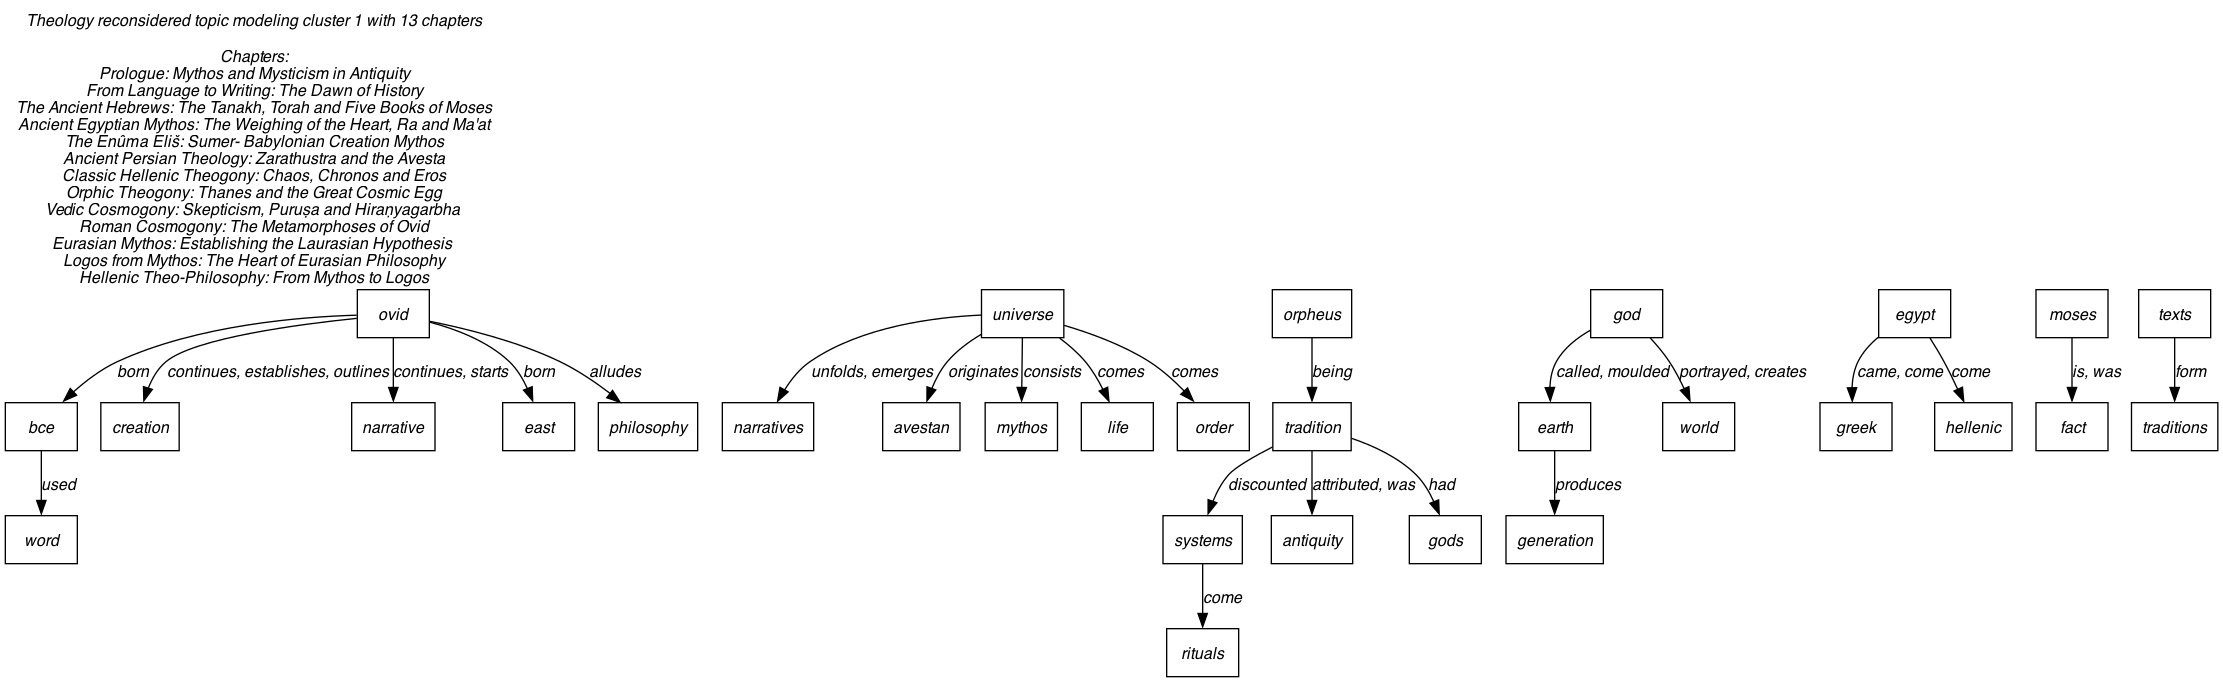

Removing the following terms:  ['subject object', 'metaphysics quality', 'static quality', 'object metaphysics', 'dynamic quality', 'one', 'even', 'subjectobject', 'motorcycle maintenance', 'subjects objects', 'aspect quality', 'subjectobject metaphysics', 'zen art', 'art motorcycle']


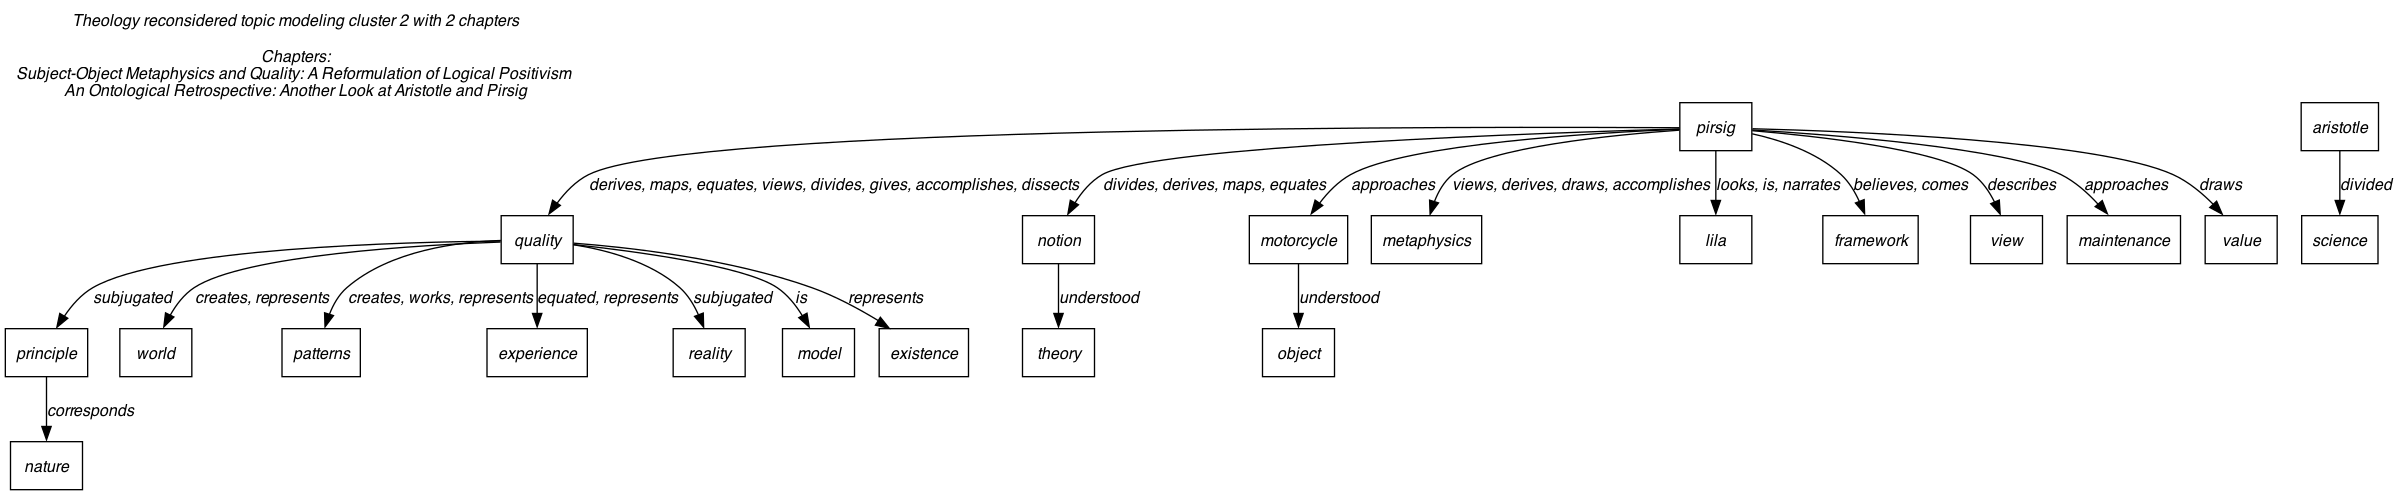

Removing the following terms:  ['suffering', 'one', 'also', 'well', 'first', 'works', 'form knowledge', 'said', 'know', 'two']


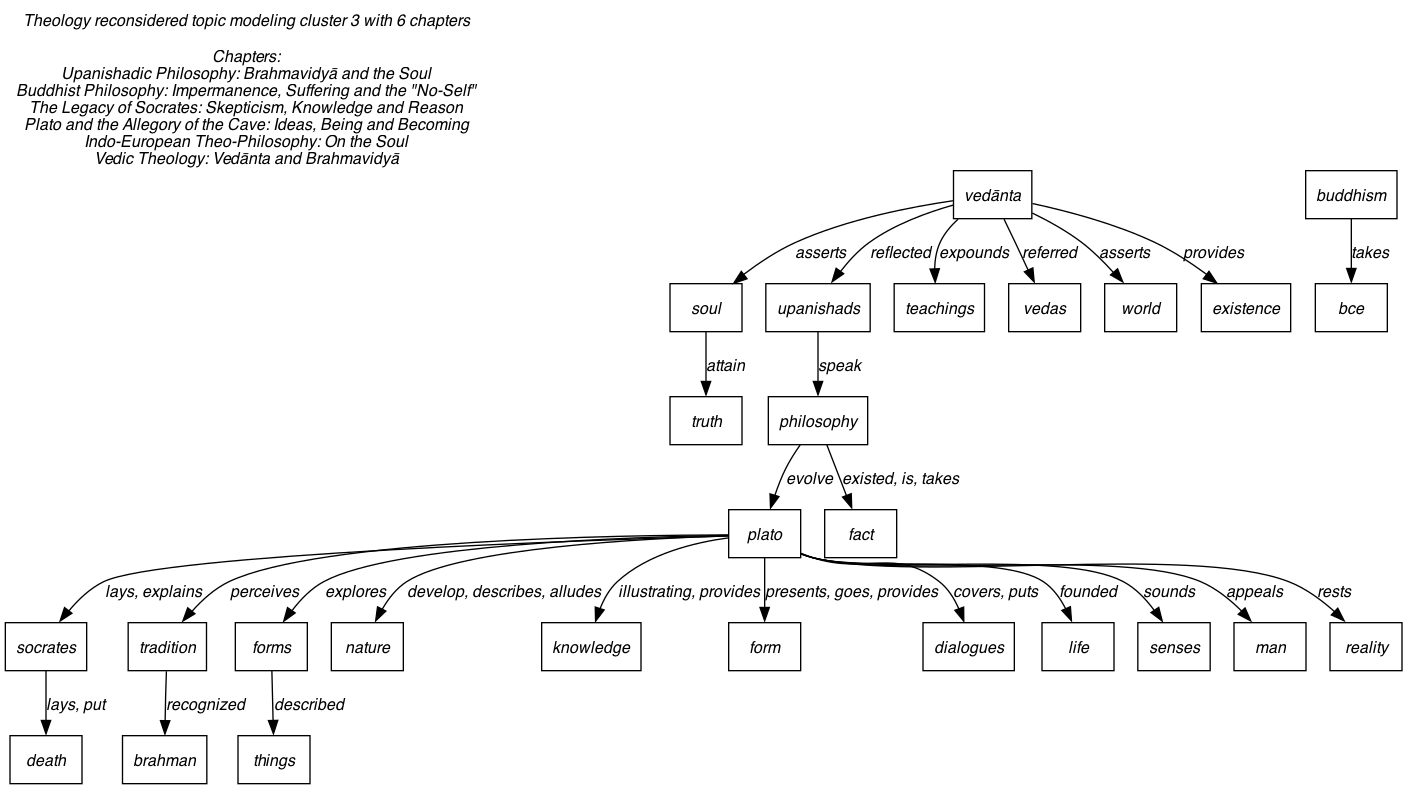

Removing the following terms:  ['well', 'theo', 'theo philosophical', 'also', 'one', 'find', 'even', 'first', 'much', 'theophilosophical', 'indo', 'throughout eurasia']


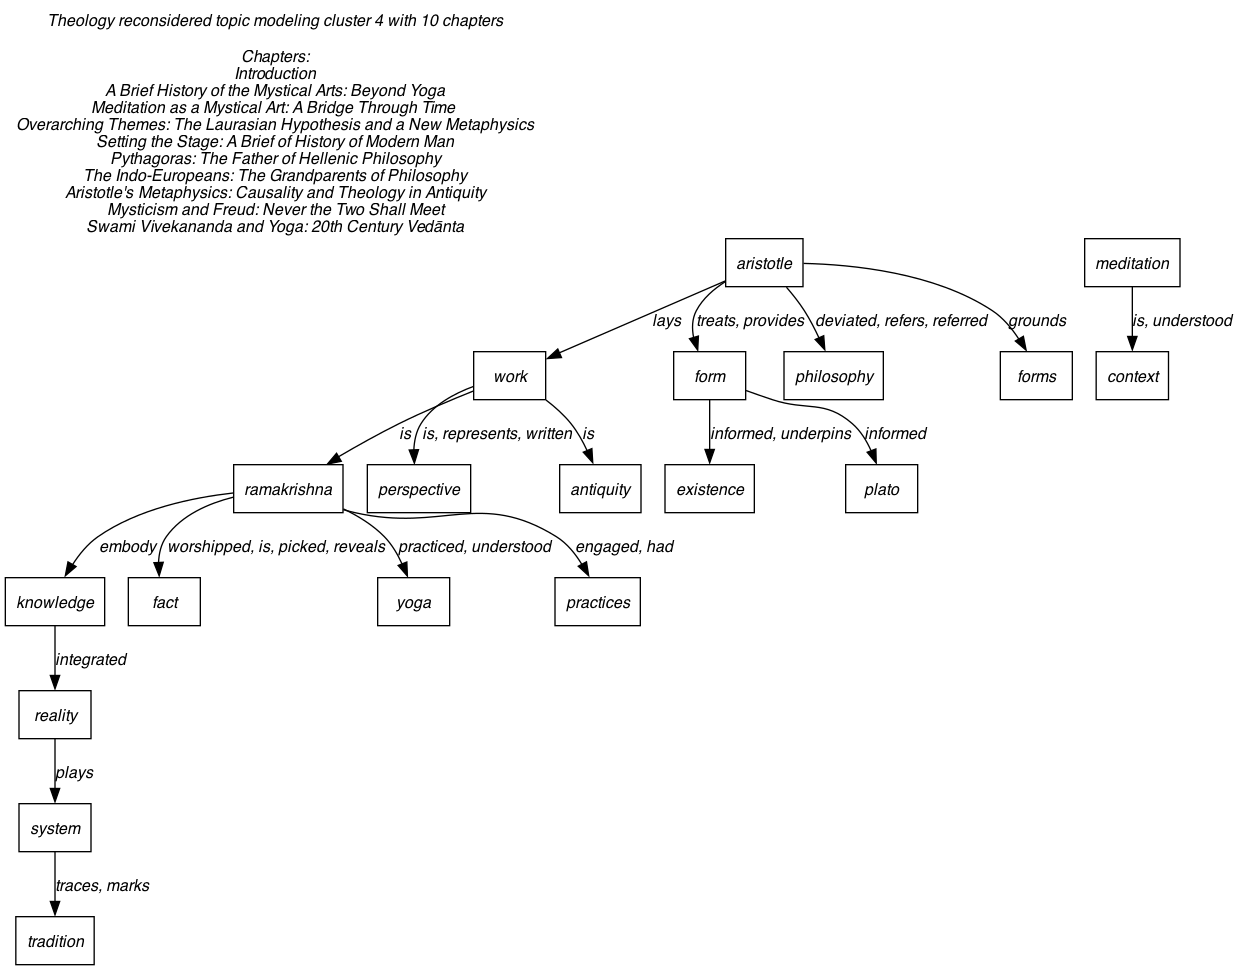

Removing the following terms:  ['quantum theory', 'quantum mechanics', 'classical mechanics', 'one', 'well', 'even', 'defined', 'underlying']


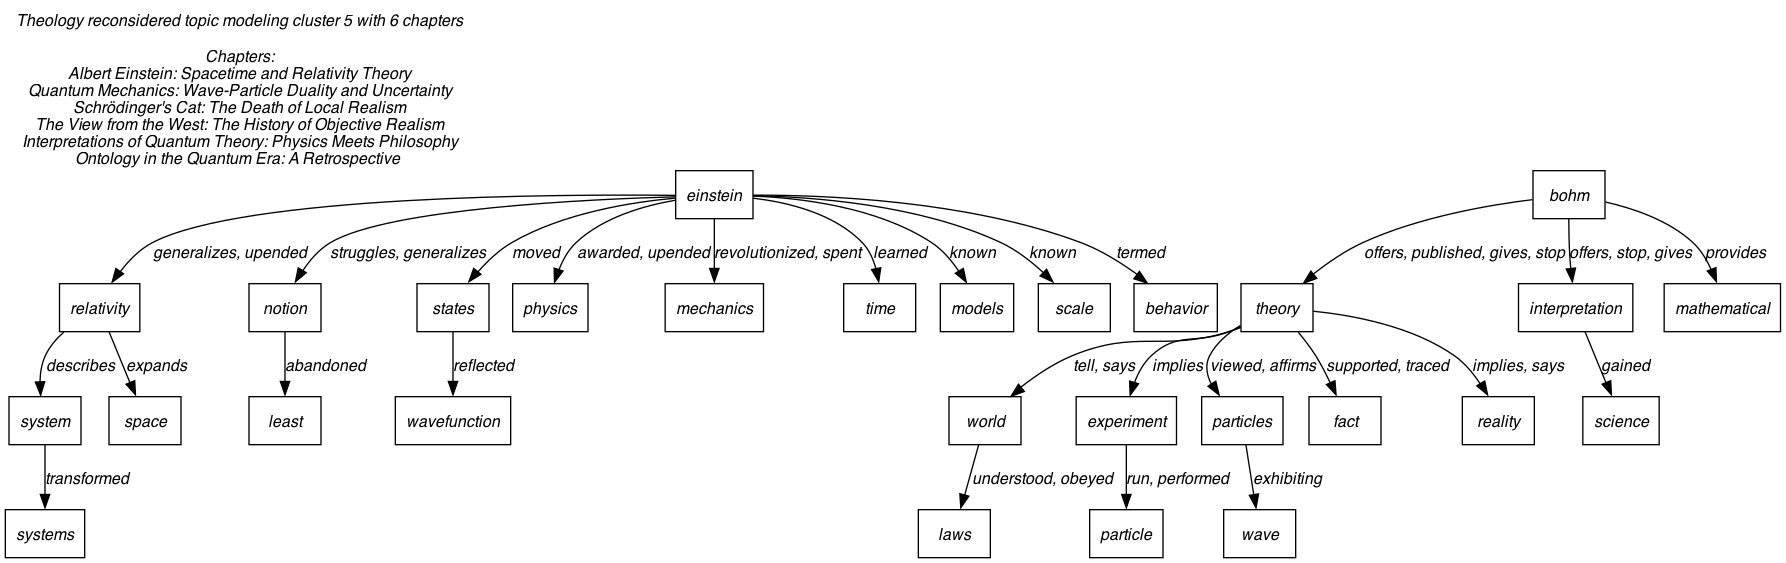

Removing the following terms:  ['one', 'well', 'also', 'metaphysics awareness']


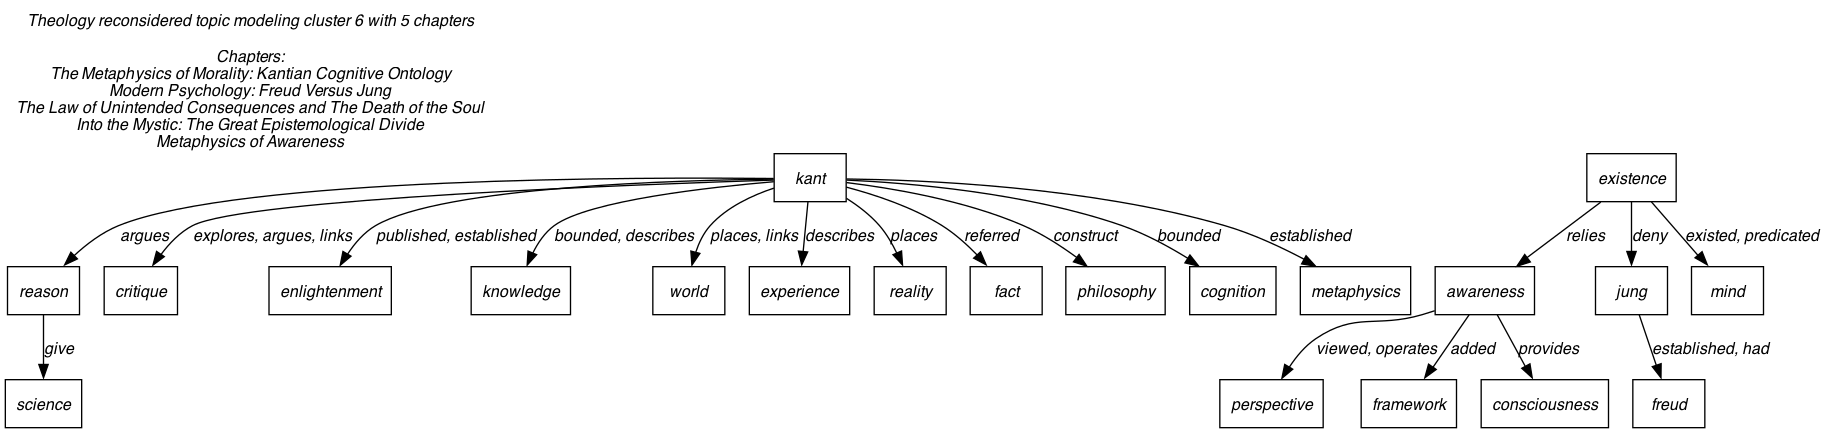

Removing the following terms:  ['one', 'ancient chinese', 'also', 'heaven earth', 'well', 'first', 'dàodé jīng', 'zhou dynasty', 'chinese antiquity', 'writing', 'see', 'form', 'chinese philosophical', 'two', 'even', 'written', 'eight']


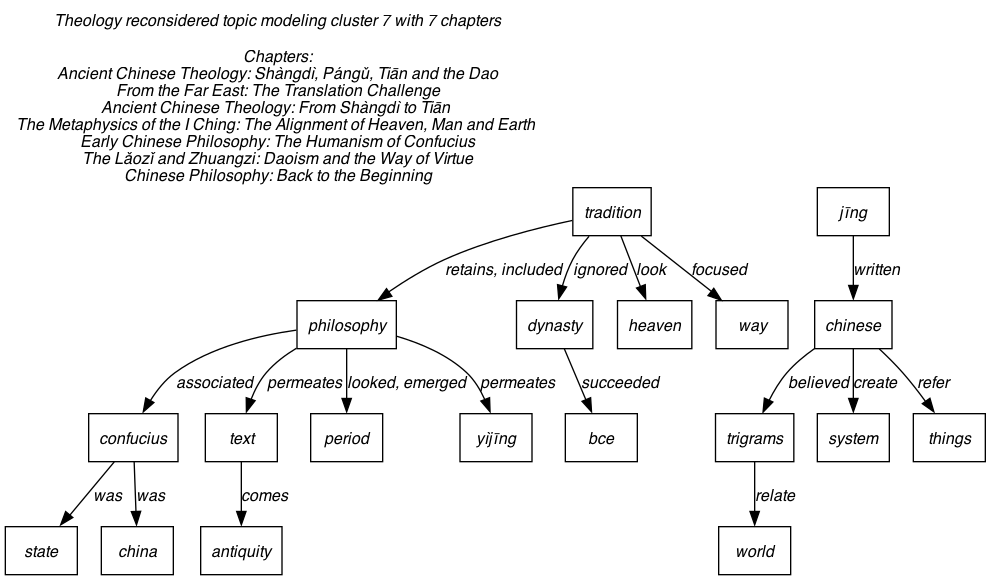

Removing the following terms:  ['al', 'one', 'also', 'well', 'first', 'works', 'muammad', 'salvation', 'old testament', 'qurn']


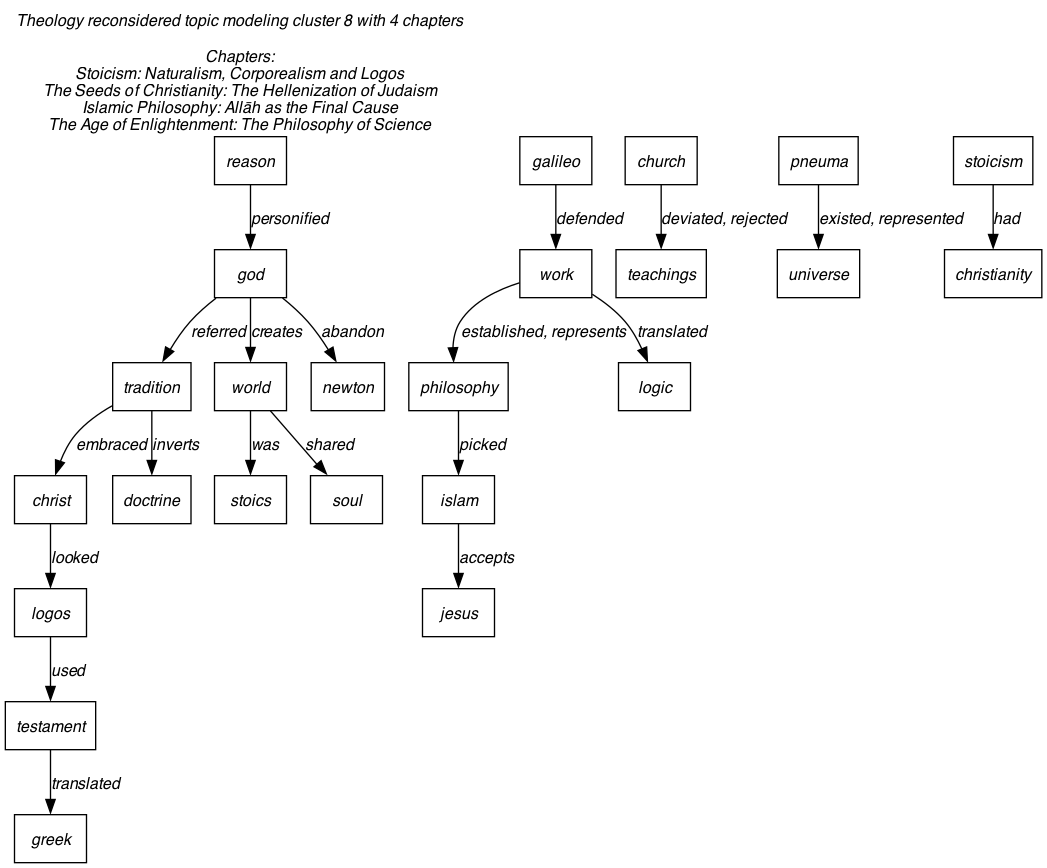

In [15]:
use_key_terms = True

# Specify the chapters used in the analysis.
for cluster in range(1, NUM_TOPICS + 1):
    # print("Cluster: #", cluster)
    chosen_chapters = clusters[cluster]

    chapter_titles = [titles[i] for i in chosen_chapters]
    # print("Chosen chapters \n")
    # for title in chapter_titles:
    #     print(title)

    # Specify the number of top words to use.
    n = max(50, len(chosen_chapters) * 5)

    text_per_chapter = []
    for chapter_idx in chosen_chapters:
        text_per_chapter.append(chapters[chapter_idx])

    tf_idf_pre_filtering = get_word_types_with_tf_idf(
        text_per_chapter,
        "tf",
        skip_stopwords=True,
        include_verbs=False,
        include_determiners=False,
        include_pronouns=False,
        include_adverbs=False,
        include_numbers=False,
    )

    if use_key_terms:
        current_level_words = current_level_words = filter_topic_modeling_key_terms(
            key_terms=key_terms_per_cluster[cluster],
            tf_idf_word_types=tf_idf_pre_filtering,
            verbose=True,
        )
    else:
        current_level_words = tf_idf_pre_filtering.head(n)["word"].values

    # Create a list of all verses of the chosen books.
    all_verses = []
    for chapter_idx in chosen_chapters:
        all_verses.extend(sentences_per_chapter[chapter_idx])
    directed_relations, relations_to_verbs = get_directed_relations(
        top_n_words=current_level_words,
        all_verses=all_verses,
        verbose=False,
    )
    ordered_directed_relations = order_directed_relations(
        directed_relations=directed_relations,
        tf_idf_pre_filtering=tf_idf_pre_filtering,
        order_by="product",
        include_ordering_wrt_occurences=True,
        verbose=False,
    )
    ontology_hierarchy, words_with_parents = construct_ontology_hierarchy(
        ordered_directed_relations=ordered_directed_relations,
    )
    # print_hierarchy_tree_from_ontology(
    #     ontological_hierarchy=ontology_hierarchy,
    #     words_with_parents=words_with_parents,
    # )
    draw_hierarchy_tree_from_ontology(
        ontological_hierarchy=ontology_hierarchy,
        relations_to_verbs=relations_to_verbs,
        title="Theology reconsidered topic modeling cluster "
        + str(cluster)
        + " with "
        + str(len(chosen_chapters))
        + " chapters",
        topic_modelling_chapters=chapter_titles,
    )